Modified version of ideal-age-ventilation.ipynb (https://github.com/NOAA-GFDL/OM4-figures/blob/master/ideal-age-ventilation.ipynb)

In [1]:
# Don't display filter warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
from dask.diagnostics import ProgressBar
from wmt_inert_tracer.preprocessing import preprocessing
import matplotlib.pyplot as plt
import matplotlib.colors # For truncate_colormap()
import cmocean.cm as cmo
%matplotlib inline

In [3]:
def agefrac_dxdz(ds, max_age, depth=2500):
    """Integrates age fraction in x and z below depth"""
    age_frac = 1 - ds.agessc[-1]/max_age
    dxdz = ds.volcello.mean('time')/ds.dyt
    dz = ds.lev_outer[1:].values-ds.lev_outer[:-1].values
    wgt = np.maximum(0, np.minimum(1, ( ds.lev_outer[1:].values - depth ) /dz))
    return ((age_frac * dxdz).sum('x').T * wgt).sum('lev')

In [4]:
platfrom = 'gfdl.ncrc4-intel18-prod-openmp'
tprd = '008*'
yr_ed = '0090'
ddict = {mod:{} for mod in ['CM4_piControl_c192_OM4p125_v7','CM4_piControl_c192_OM4p125_v6_alt1','CM4_piControl']}
for mod in ddict:
    
    pp = 'ocean_annual_z_d2' if mod in ['CM4_piControl_c192_OM4p125_v5','CM4_piControl_c192_OM4p125_v6_alt1',
                                        'CM4_piControl_c192_OM4p125_v6_alt2','CM4_piControl_c192_OM4p125_v6_alt3',
                                        'CM4_piControl_c192_OM4p125_v7'] else 'ocean_annual_z'
    pp_dir = '/pp/%s/ts/annual/10yr/'%pp
    
    rootdir = '/home/Jan-erik.Tesdal/data/raw/%s_C/ocean_annual_z/'%mod if mod=='CM4_piControl' \
                else '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/%s/'%mod+platfrom+pp_dir if mod=='CM4_piControl_c192_OM4p25' \
                else '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/%s/'%mod+platfrom+pp_dir
    print(rootdir)
    
    vars_ds = xr.open_mfdataset(rootdir+pp+'.%s.agessc.nc'%tprd, use_cftime=True, drop_variables=['average_DT','average_T1','average_T2'])
    vars_ds['volcello'] = xr.open_mfdataset(rootdir+pp+'.%s.volcello.nc'%tprd, use_cftime=True).volcello
    vars_ds['Kd_interface'] = xr.open_mfdataset(rootdir+pp+'.%s.Kd_interface.nc'%tprd, use_cftime=True).Kd_interface
    
    print(str(vars_ds.time.values[0])[:10],'to',str(vars_ds.time.values[-1])[:10])
    max_age_total = np.ceil(vars_ds.agessc[-1].max().values)
    print('Maximum age:',max_age_total,'years')
    
    grid = xr.open_dataset(rootdir[:-9]+'monthly/ocean_monthly.static.nc') if mod == 'CM4_piControl'\
            else xr.open_dataset(rootdir[:-15]+pp+'.static.nc')
    
    #print(pd.concat([vars_ds.xh.to_series().reset_index(drop=True), grid.xh.to_series().reset_index(drop=True), 
     #                vars_ds.yh.to_series().reset_index(drop=True), grid.yh.to_series().reset_index(drop=True)], axis=1))
    
    if mod in ['CM4_piControl_c192_OM4p125_v5','CM4_piControl_c192_OM4p125_v6_alt1',
               'CM4_piControl_c192_OM4p125_v6_alt2','CM4_piControl_c192_OM4p125_v6_alt3',
               'CM4_piControl_c192_OM4p125_v7']:
        grid = grid.assign_coords({'xh':vars_ds.xh,'yh':vars_ds.yh})
        
    ds = preprocessing(vars_ds, grid, decode_times=False, verbose=False)
    ds = ds.sel(time=slice(None,yr_ed))
    
    max_age = np.ceil(ds.agessc[-1].max().values)
    print('Maximum age:',max_age,'years')
    
    print(str(ds.time.values[0])[:10],'to',str(ds.time.values[-1])[:10])
    ds['dyt'] = grid.dyt.rename({'yh':'y', 'xh':'x'})
    with ProgressBar():
        ds['agefrac'] = agefrac_dxdz(ds,max_age).load()
         
    ddict[mod]['ds'] = ds
    ddict[mod]['max_age'] = max_age

/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z_d2/ts/annual/10yr/
0081-07-02 to 0090-07-02
Maximum age: 90.0 years
Maximum age: 90.0 years
0081-07-02 to 0090-07-02
[########################################] | 100% Completed | 19.9s
/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z_d2/ts/annual/10yr/
0081-07-02 to 0090-07-02
Maximum age: 90.0 years
Maximum age: 90.0 years
0081-07-02 to 0090-07-02
[########################################] | 100% Completed | 18.1s
/home/Jan-erik.Tesdal/data/raw/CM4_piControl_C/ocean_annual_z/
0081-07-02 to 0090-07-02
Maximum age: 90.0 years
Maximum age: 90.0 years
0081-07-02 to 0090-07-02
[########################################] | 100% Completed | 15.6s


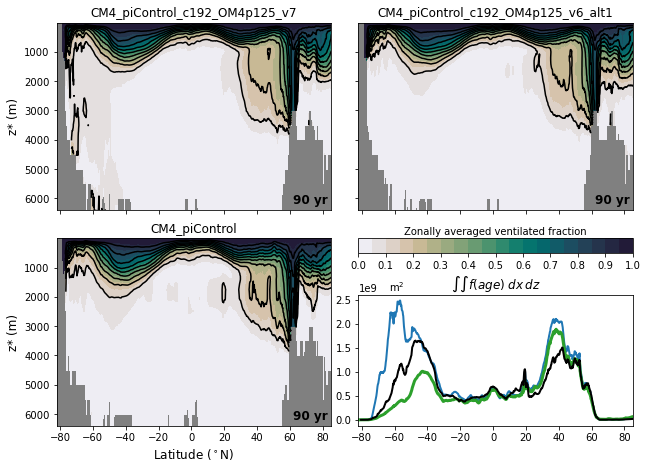

In [5]:
cstr = ['tab:blue','tab:green','k']

fig, axarr = plt.subplots(2, 2, figsize=(10,7))
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.15, wspace=0.1)

axs = axarr.flat

for i, mod in enumerate(ddict):
    
    if i<3:
        p = (1 - (ddict[mod]['ds'].agessc[-1].mean('x')/ddict[mod]['max_age']))\
            .plot.contourf(ax=axs[i], x='y', y='lev', yincrease=False, levels=np.arange(0,1.05,.05), cmap=cmo.rain, vmin=0, vmax=1,
                       add_colorbar=False, add_labels=False)
        (1 - (ddict[mod]['ds'].agessc[-1].mean('x')/ddict[mod]['max_age']))\
            .plot.contour(ax=axs[i], x='y', y='lev', yincrease=False, levels=np.arange(0,1.1,.1), colors='k', add_labels=False)
        axs[i].set_xlim([-82,85])
        axs[i].set_ylim([6400,1.0])
        axs[i].set_xticks(np.arange(-80,100,20))
        axs[i].set_yticks(np.arange(6000,0,-1000))
        axs[i].tick_params(axis='both', which='both', labelsize=10)
        axs[i].text(0.99, 0.02, '%1.0f yr'%ddict[mod]['max_age'], ha='right', va='bottom', fontsize=12, 
                    fontweight='bold',transform=axs[i].transAxes)
        axs[i].set_facecolor('gray')
        axs[i].set_title(mod, fontsize=12)
        if i <2 :
            axs[i].set_xticklabels([])
        else:
            axs[i].set_xlabel('Latitude ($^\circ$N)', fontsize=12)
        
        if i in [0,2]:
            axs[i].set_ylabel('z* (m)', fontsize=12)
        else:
            axs[i].set_yticklabels([])
            

for i, mod in enumerate(ddict):
    axs[3].plot(ddict[mod]['ds'].y[:], ddict[mod]['ds'].agefrac, c=cstr[i], lw=3 if i==1 else 2,label=mod)
axs[3].set_title('$\int\int f(age) \; dx \, dz$')
#axs[3].set_ylim([0,1.4e10])
axs[3].set_xlim([-82,85])
axs[3].set_xticks(np.arange(-80,100,20))
#axs[3].set_yticks(np.arange(0,1.4,.2)*1e10)
axs[3].text(.11,1.026,'m$^2$',fontsize=10,transform=axs[3].transAxes)
#axs[3].legend(fontsize=9,frameon=False, fancybox=False)

# Shrink line plot
bb = axs[3].get_position()
axs[3].set_position([bb.x0, bb.y0, bb.x1-bb.x0, (bb.y1-bb.y0)*.7])

# Add colorbar
cbar_ax = fig.add_axes([bb.x0, bb.y1-.03, bb.x1-bb.x0, 0.03])
cb = fig.colorbar(p, cax=cbar_ax, ticks=np.arange(0,1.1,.1), orientation='horizontal')
cb.ax.xaxis.set_label_position('top')
cl = cb.set_label('Zonally averaged ventilated fraction')

#plt.savefig('/work/jet/figure.png', dpi=None, facecolor='w', edgecolor='w',
#            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

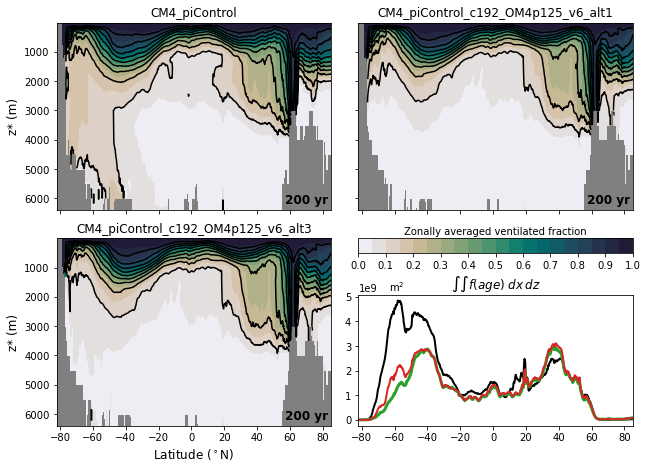

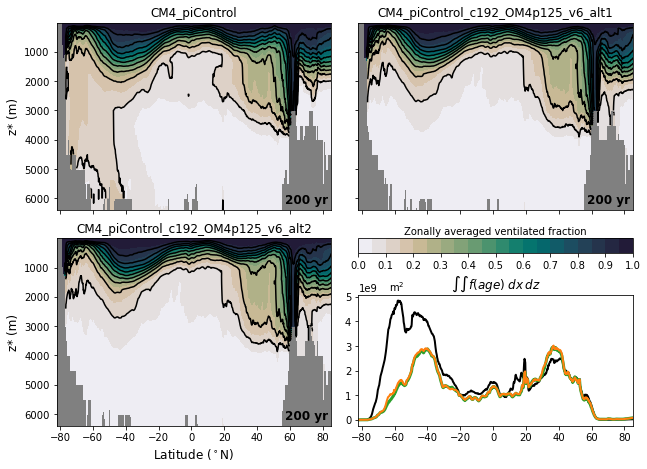

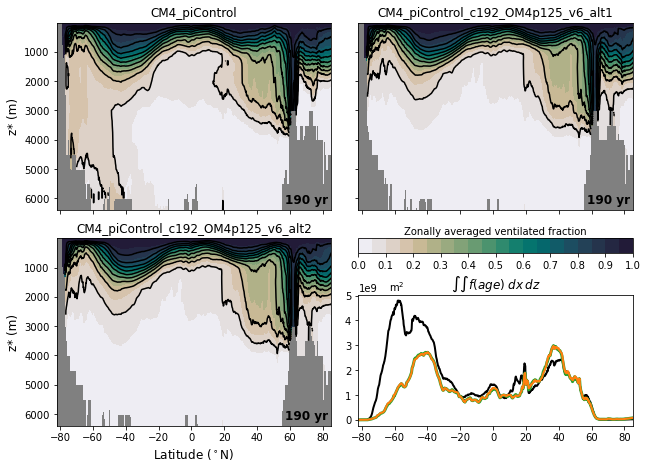

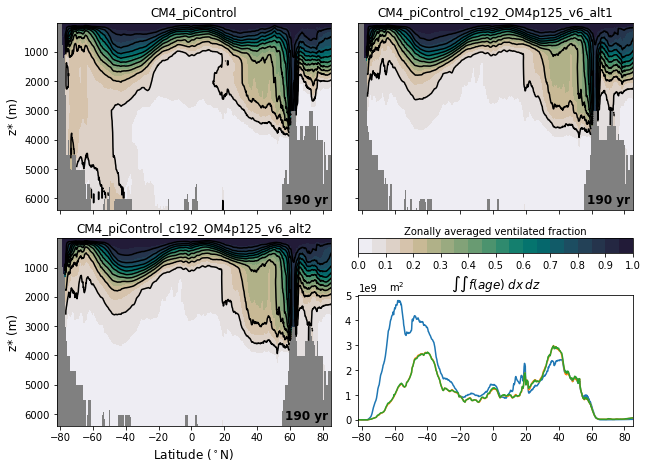

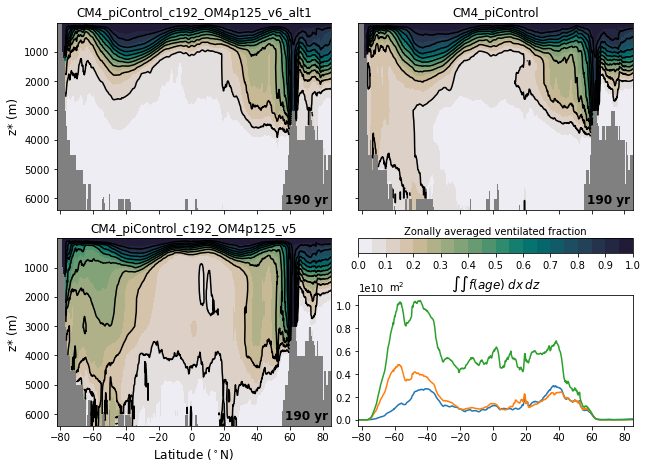

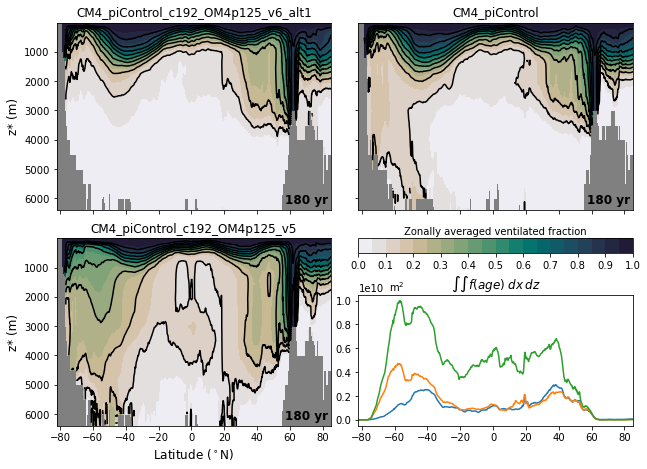

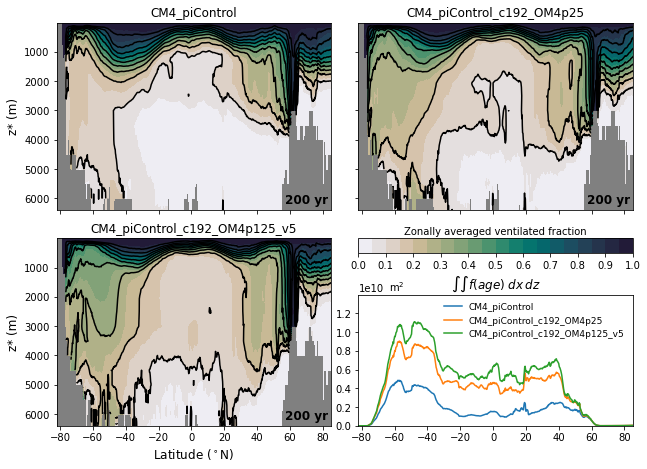